In [1]:
# 1) Import required packages and specify scenario
import message_ix
import ixmp as ix
from itertools import product
from timeit import default_timer as timer
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
fs = 24
plt.style.use('seaborn-ticks')
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.axisbelow'] = True


<IPython.core.display.Javascript object>

Additional functions

In [2]:
def convert_series_into_2D_matrix(series,lvls,x_i_str,x_j_str):
    curtailment_df = pd.DataFrame(index=lvls)
    for ind in curtailment_df.index[0:-1]:
        df_curt = series.loc[series.index.str.contains(x_i_str[0] + str(ind))]["0"]
        length = len(df_curt)
        length_dif = length - len(curtailment_df.index)
        if length_dif < 0:
            for i in range(abs(length_dif)):
                bin_add = x_i_str + str(ind) + x_j_str[0] + str(length + i) 
                df_curt_T = df_curt.T
                df_curt_T[bin_add] = np.nan
        curtailment_df[ind] = df_curt.values
    return curtailment_df

# Step 0) Fetch PyPSA-Eur metrics

In [3]:
# NB! In building these "marginal curtailment matrices", we have (for now) assumed that the case with wind penetration with 10 % solar corresponds to the case with 0 solar. 
# It is not expected to have large impact, but can always be finetuned by running a pure wind scenario in PyPSA-Eur.

# 0.1) Read .csv files as dataframes
wind_shares_pypsa = pd.read_csv("../pypsa/data_for_message/wind_shares.csv",index_col=0)
solar_shares_pypsa = pd.read_csv("../pypsa/data_for_message/solar_shares.csv",index_col=0)

delta_df1_dx1 = pd.read_csv("../pypsa/data_for_message/wind_curtailment_delta_df1_dx1.csv",index_col=0)
delta_df1_dx2 = pd.read_csv("../pypsa/data_for_message/wind_curtailment_delta_df1_dx2.csv",index_col=0)
delta_df2_dx1 = pd.read_csv("../pypsa/data_for_message/solar_curtailment_delta_df2_dx1.csv",index_col=0)
delta_df2_dx2 = pd.read_csv("../pypsa/data_for_message/solar_curtailment_delta_df2_dx2.csv",index_col=0)

# convert dataframes into dictionaries
solar_curt_pypsa_dict = delta_df2_dx2.to_dict()["0"]
wind_curt_pypsa_dict = delta_df1_dx1.to_dict()["0"]
solar_curt_pypsa_dict.update(wind_curt_pypsa_dict)
curt_pypsa_dict = solar_curt_pypsa_dict.copy()
wind_share_pypsa_dict = wind_shares_pypsa.to_dict()["0"]
solar_share_pypsa_dict = solar_shares_pypsa.to_dict()["0"]
solar_share_pypsa_dict.update(wind_share_pypsa_dict)
vre_share_pypsa_dict = solar_share_pypsa_dict.copy()

# Visualization of "gamma" coefficients

In [4]:
wind_share_matrix = convert_series_into_2D_matrix(wind_shares_pypsa,
                                                      lvls=[1,2,3,4,5,6,7],
                                                      x_i_str="wind_curtailment_w",
                                                      x_j_str="solar")
wind_share_matrix

,1,2,3,4,5,6
1,0.3,0.4,0.5,0.6,0.7,0.9
2,0.3,0.4,0.5,0.6,0.7,0.9
3,0.3,0.4,0.5,0.6,0.7,0.9
4,0.3,0.4,0.5,0.6,0.7,NaN
5,0.3,0.4,0.5,0.6,0.7,NaN
6,0.3,0.4,0.5,0.6,NaN,NaN
7,0.3,0.4,NaN,NaN,NaN,NaN


In [5]:
delta_df1_dx1_matrix = convert_series_into_2D_matrix(delta_df1_dx1,
                                                      lvls=[1,2,3,4,5,6,7],
                                                      x_i_str="wind_curtailment_w",
                                                      x_j_str="solar")
delta_df1_dx1_matrix

,1,2,3,4,5,6
1,0.0798,0.0323,0.1852,0.1960,0.1704,0.1301
2,0.1515,0.0844,0.2113,0.1375,0.1551,0.1020
3,0.1828,0.0693,0.1927,0.1209,0.1746,0.1045
4,0.1912,0.0644,0.1862,0.1265,0.1592,NaN
5,0.1935,0.0644,0.1863,0.1191,0.1646,NaN
6,0.1942,0.0647,0.1849,0.1205,NaN,NaN
7,0.1958,0.0673,NaN,NaN,NaN,NaN


In [6]:
delta_df2_dx2_matrix = convert_series_into_2D_matrix(delta_df2_dx2,
                                                      lvls=[1,2,3,4,5,6,7],
                                                      x_i_str="solar_curtailment_w",
                                                      x_j_str="wind")
delta_df2_dx2_matrix

,1,2,3,4,5,6
1,0.1585,0.4922,0.1951,0.0954,0.0303,0.0175
2,0.2105,0.4966,0.1891,0.0700,0.0133,0.0089
3,0.2430,0.5060,0.1708,0.0498,0.0122,0.0072
4,0.2771,0.5095,0.1517,0.0349,0.0123,NaN
5,0.3070,0.5221,0.1254,0.0261,0.0044,NaN
6,0.3351,0.5146,0.1067,0.0218,NaN,NaN
7,0.3749,0.4997,NaN,NaN,NaN,NaN


################################

In [7]:
def calculate_total_x_curtailment(x1,x2,delta_df1_dx1_matrix,d,phi):
    # ------------------------------------
    # 1) calculate wind curtailment in every bin of the wind penetration
    wind_curtailment_s = {}
    wind_curtailment_s_matrix = {}
    for j in np.arange(1,8):
        wind_curtailment_s_lst = []
        for i in np.arange(1,7):
            metric = delta_df1_dx1_matrix.loc[j,i]*(x1-phi[i-1]*d) if (x1 > phi[i-1]*d) else np.nan
            if not np.isnan(metric):
                wind_curtailment_s_lst.append(metric)
                wind_curtailment_s_matrix["s" + str(j) + "w" + str(i)] = metric
            else:
                wind_curtailment_s_matrix["s" + str(j) + "w" + str(i)] = np.nan
        wind_curtailment_s["s" + str(j)] = round(sum(wind_curtailment_s_lst),3)

    # 2) calculate the increase in curtailment due to increase in solar 
    wind_rows = {}
    for j in np.arange(2,8):
        for i in np.arange(1,7):
            curt_step_1 = wind_curtailment_s_matrix["s" + str(j) + "w" + str(i)]
            curt_step_0 = wind_curtailment_s_matrix["s" + str(j-1) + "w" + str(i)]

            if not np.isnan(curt_step_0):
                wind_rows[i,j-1] = curt_step_1 - curt_step_0

    delta_wind_curtailment_s = {1:[],2:[],3:[],4:[],5:[],6:[]}
    for wind_no in np.arange(1,7):
        for key in list(wind_rows.keys()):
            if key[1] == wind_no:
                delta_wind_curtailment_s[wind_no].append(wind_rows[(key)])

    delta_curtailment = {}
    for i in range(len(delta_wind_curtailment_s.keys())):
        delta_curtailment[i] = pd.Series(delta_wind_curtailment_s[i+1]).dropna().sum()

    # 3) calculate "gradient" in the solar direction
    df1_dx2 = {}
    for i in range(len(delta_curtailment.keys())):
        df1 = delta_curtailment[i]
        dx2 = (phi[i+1] - phi[i])*100

        df1_dx2[phi[i]] = df1/dx2

    # 4) additional curtailment from when moving "upwards" in the 2D curtailment matrix
    add_curtailment = {}
    for i in range(len(df1_dx2.keys())):
        key = list(df1_dx2.keys())[i]
        key_pct = key*100
        x2_dif = min((x2-key_pct),(phi[i+1]-phi[i])*100)
        add_curtailment[key] = df1_dx2[key]*x2_dif if (x2 > key_pct) else 0

    add_curtailment_sum = sum(add_curtailment.values())

    total_wind_curtailment_ij = add_curtailment_sum + wind_curtailment_s["s1"]
    total_wind_curtailment_ij_pct = total_wind_curtailment_ij/x1*100
    
    return round(total_wind_curtailment_ij_pct,2)

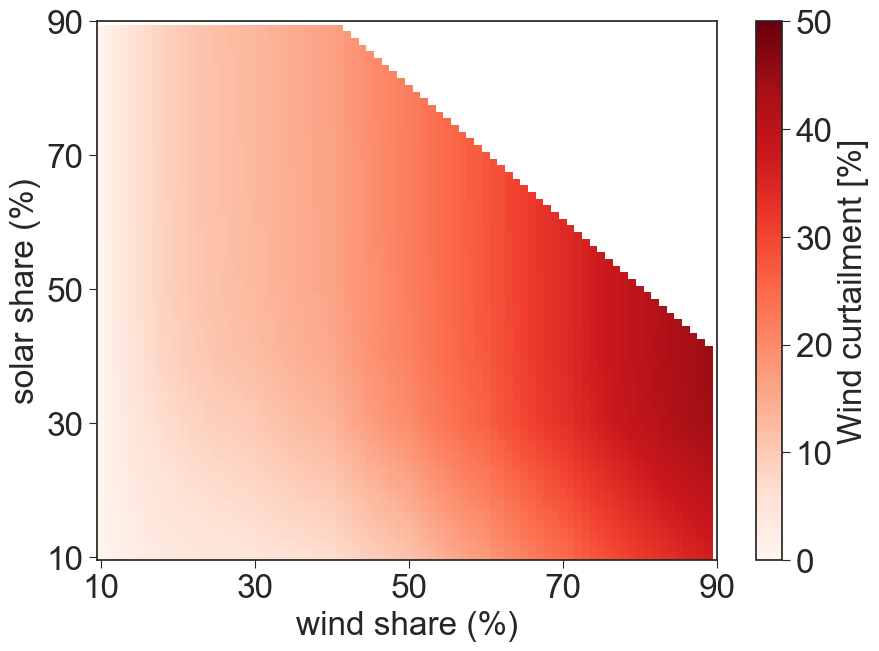

In [8]:
lower = 10
upper = 90
delta_x1 = 1 #0.3
delta_x2 = 1 #0.3

x1_range = np.arange(lower,upper,delta_x1) # MWh # Wind share 
x2_range = np.arange(lower,upper,delta_x2) # MWh # Solar share
d = 100. # MWh
phi = [0.1,0.3,0.4,0.5,0.6,0.7,0.9]

tot_wind_curtailment_pct = np.zeros([len(x2_range),len(x1_range)])
for i in range(len(x1_range)):
    for j in range(len(x2_range)):
        if not x1_range[i] + x2_range[j] > 130:
            tot_wind_curtailment_pct[j,i] = calculate_total_x_curtailment(x1_range[i],x2_range[j],delta_df1_dx1_matrix,d,phi)
        else:
            tot_wind_curtailment_pct[j,i] = np.nan        
tot_wind_curtailment_pct_df = pd.DataFrame(tot_wind_curtailment_pct)

fig, ax = plt.subplots(figsize=(10,7))
colormap = plt.cm.Reds
im = ax.pcolormesh(tot_wind_curtailment_pct_df.columns, 
                   tot_wind_curtailment_pct_df.index, 
                   tot_wind_curtailment_pct_df.values,
                   cmap=colormap,
                   vmax=50)

ax.set_xticks(np.arange(0,len(x1_range)+len(x1_range)/4,len(x1_range)/4))
ax.set_xticklabels([lower,"30","50","70",upper])

ax.set_yticks(np.arange(0,len(x2_range)+len(x2_range)/4,len(x2_range)/4))
ax.set_yticklabels([lower,"30","50","70",upper])

ax.set_xlabel("wind share (%)")
ax.set_ylabel("solar share (%)")

cb = fig.colorbar(im, ax=ax)
cb.set_label("Wind curtailment [%]")

#fig.savefig("wind_curtailment_continuous_space.png",
#            bbox_inches="tight",
#            dpi=300)

In [19]:
wind_curt = tot_wind_curtailment_pct_df.iloc[::-1]
wind_curt.index = np.arange(10,90,1)[::-1]
wind_curt.columns = np.arange(10,90,1)

In [44]:
wind_curt.loc[20,80]

35.45

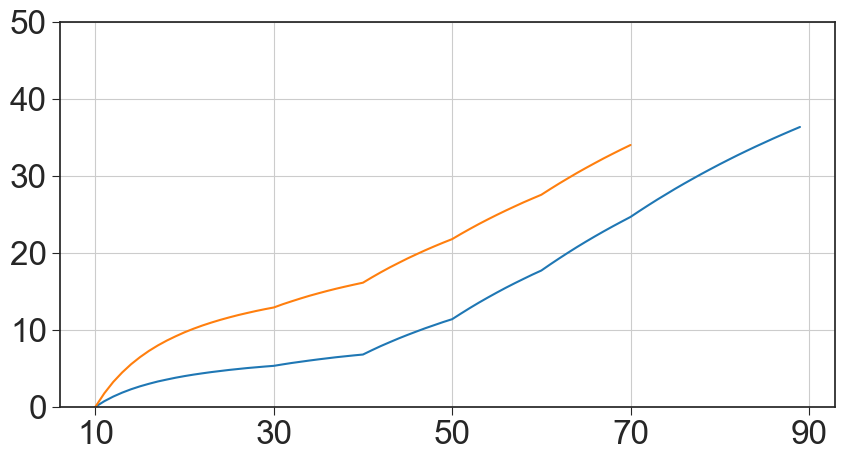

In [326]:
fig, ax = plt.subplots(figsize=(10,5))
tot_wind_curtailment_pct_df.loc[0].plot()
tot_wind_curtailment_pct_df.loc[50].plot()

ax.set_xticks(np.arange(0,len(x1_range)+len(x1_range)/4,len(x1_range)/4))
ax.set_xticklabels([lower,"30","50","70",upper])
ax.set_ylim(0,50)

ax.grid()

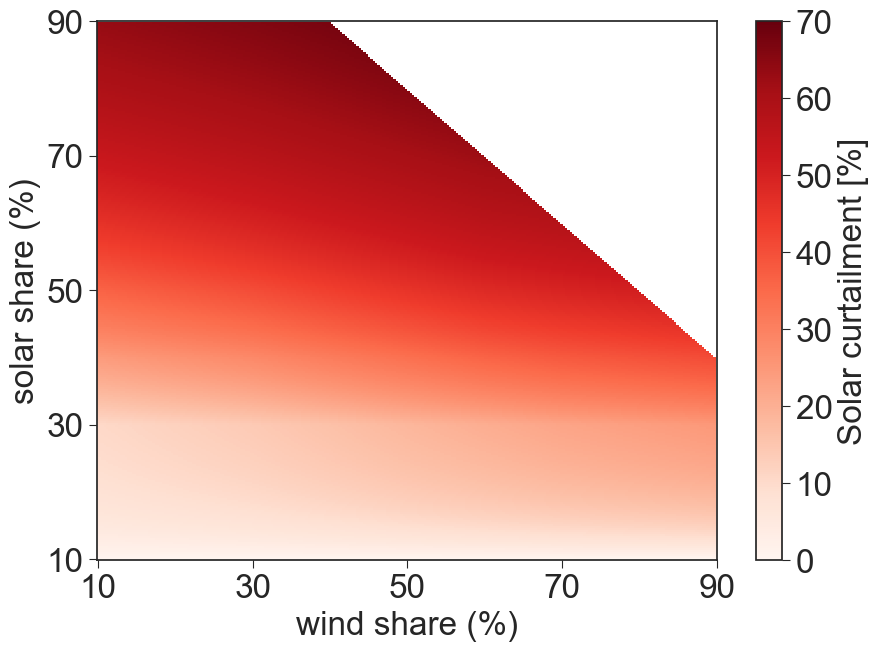

In [316]:
lower = 10
upper = 90

delta_x1 = 0.3
delta_x2 = 0.3

x1_range = np.arange(lower,upper,delta_x1) # MWh # Wind share 
x2_range = np.arange(lower,upper,delta_x2) # MWh # Solar share
d = 100. # MWh
phi = [0.1,0.3,0.4,0.5,0.6,0.7,0.9]

tot_solar_curtailment_pct = np.zeros([len(x2_range),len(x1_range)])
for i in range(len(x1_range)):
    for j in range(len(x2_range)):
        if not x1_range[i] + x2_range[j] > 130:
            tot_solar_curtailment_pct[j,i] = calculate_total_x_curtailment(x2_range[i],x1_range[j],delta_df2_dx2_matrix,d,phi)
        else:
            tot_solar_curtailment_pct[j,i] = np.nan        
            
tot_solar_curtailment_pct_df = pd.DataFrame(tot_solar_curtailment_pct).T

fig, ax = plt.subplots(figsize=(10,7))
colormap = plt.cm.Reds
im = ax.pcolormesh(tot_solar_curtailment_pct_df.columns, 
                   tot_solar_curtailment_pct_df.index, 
                   tot_solar_curtailment_pct_df.values,
                   cmap=colormap,
                   vmax=70)

ax.set_xticks(np.arange(0,len(x1_range)+len(x1_range)/4,len(x1_range)/4))
ax.set_xticklabels([lower,"30","50","70",upper])

ax.set_yticks(np.arange(0,len(x2_range)+len(x2_range)/4,len(x2_range)/4))
ax.set_yticklabels([lower,"30","50","70",upper])

ax.set_xlabel("wind share (%)")
ax.set_ylabel("solar share (%)")

cb = fig.colorbar(im, ax=ax)
cb.set_label("Solar curtailment [%]")

fig.savefig("solar_curtailment_continuous_space.png",
            bbox_inches="tight",
            dpi=300)

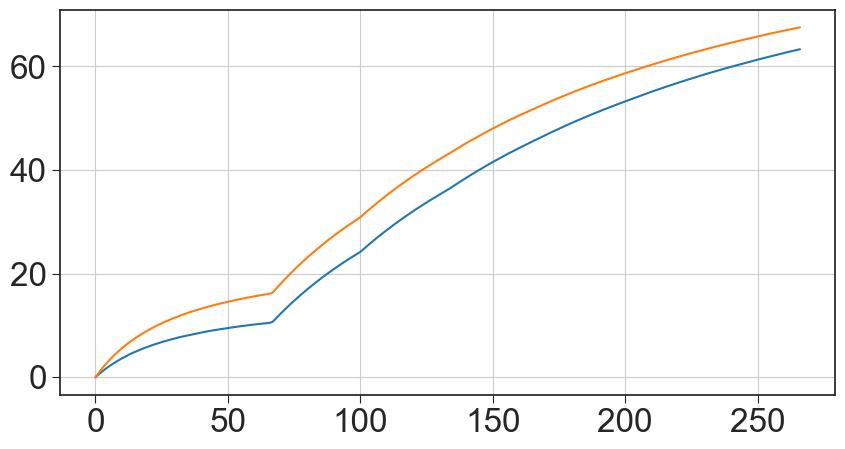

In [335]:
fig, ax = plt.subplots(figsize=(10,5))
tot_solar_curtailment_pct_df[0].plot()
tot_solar_curtailment_pct_df[100].plot()

#ax.set_xticks(np.arange(0,len(x1_range)+len(x1_range)/4,len(x1_range)/4))
#ax.set_xticklabels([lower,"30","50","70",upper])
#ax.set_ylim(0,50)

ax.grid()

#####################################

In [9]:
delta_df2_dx2_matrix = convert_series_into_2D_matrix(delta_df2_dx1,
                              lvls=[1,2,3,4,5,6,7],
                              x_i_str="solar_curtailment_s",
                              x_j_str="wind")

delta_df2_dx2_matrix

,1,2,3,4,5,6
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0525,0.0807,0.1059,0.1184,0.1224,0.1217
3,0.0129,0.0267,0.0252,0.0161,0.0144,0.0164
4,0.0026,-0.0018,-0.0071,-0.0069,-0.0055,NaN
5,-0.0069,-0.0020,-0.0042,-0.0004,-0.0046,NaN
6,-0.0036,-0.0255,-0.0398,-0.0496,NaN,NaN
7,-0.0171,-0.0252,NaN,NaN,NaN,NaN


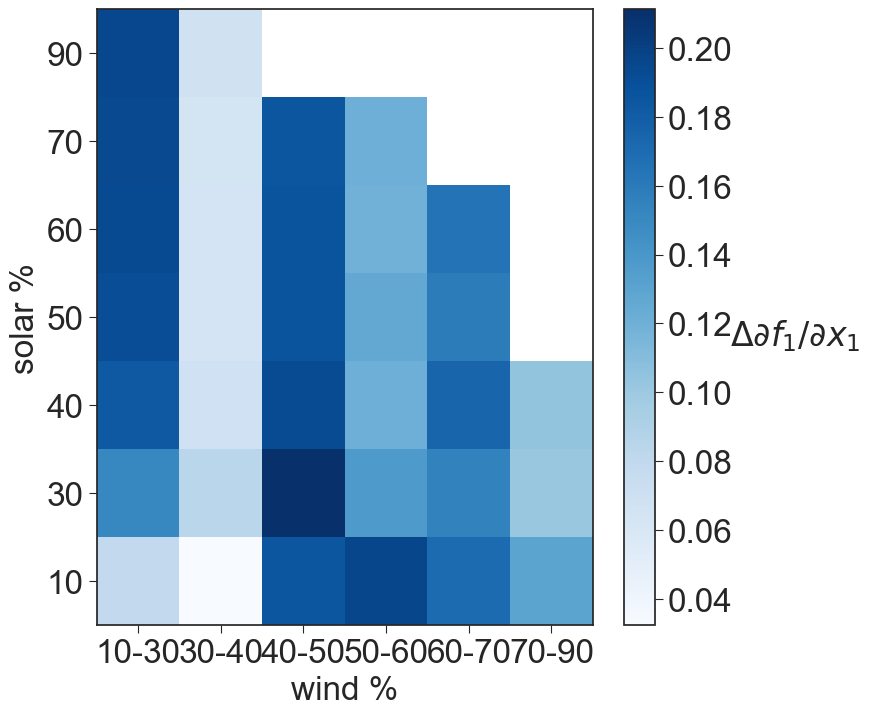

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
colormap = plt.cm.Blues
im = ax.pcolormesh(delta_df1_dx1_matrix.columns, 
                   delta_df1_dx1_matrix.index, 
                   delta_df1_dx1_matrix.values,
                   cmap=colormap)

ax.set_xticks(np.arange(1,7))
ax.set_yticks(np.arange(1,8))
ax.set_xticklabels(["10-30","30-40","40-50","50-60","60-70","70-90"])
ax.set_yticklabels(["10","30","40","50","60","70","90"])
ax.set_xlabel("wind %")
ax.set_ylabel("solar %")

cb = fig.colorbar(im, ax=ax)
cb.set_label(r"$\Delta \partial f_1/\partial x_1$",
             rotation=0,
             labelpad=45)

fig.savefig("gamma_wind_solar.png",
            bbox_inches="tight",
            dpi=300)

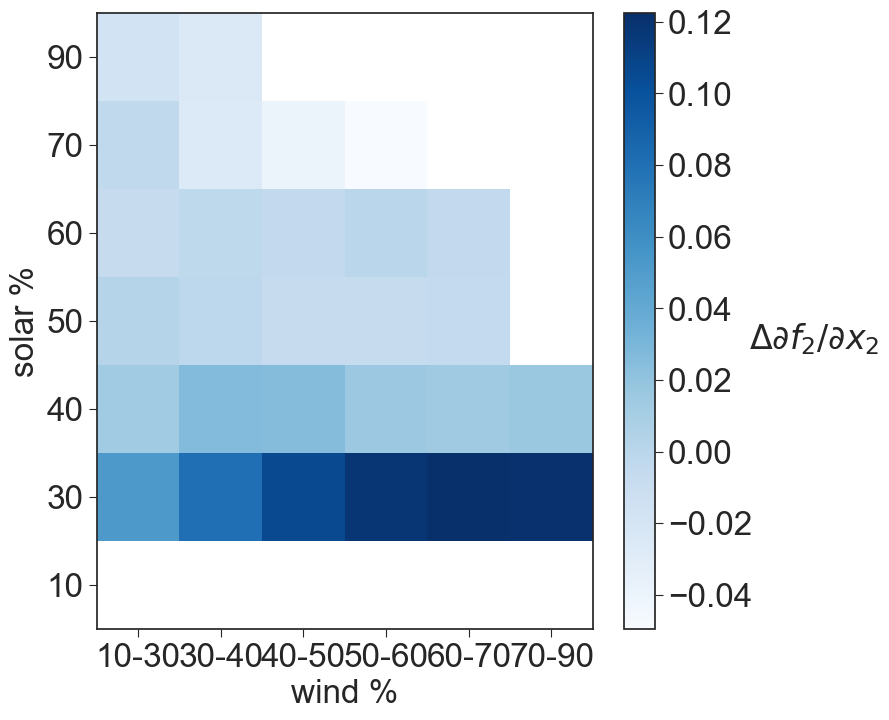

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
colormap = plt.cm.Blues
im = ax.pcolormesh(delta_df2_dx2_matrix.columns, 
                   delta_df2_dx2_matrix.index, 
                   delta_df2_dx2_matrix.values,
                   cmap=colormap)

ax.set_xticks(np.arange(1,7))
ax.set_yticks(np.arange(1,8))
ax.set_xticklabels(["10-30","30-40","40-50","50-60","60-70","70-90"])
ax.set_yticklabels(["10","30","40","50","60","70","90"])
ax.set_xlabel("wind %")
ax.set_ylabel("solar %")

cb = fig.colorbar(im, ax=ax)
cb.set_label(r"$\Delta \partial f_2/\partial x_2$",
             rotation=0,
             labelpad=45)

fig.savefig("gamma_solar_wind.png",
            bbox_inches="tight",
            dpi=300)

In [3]:
# 0.2) Create dictionary that represents the 2D vre penetration matrix

# number of bins (determined from the PyPSA-Eur data):
no_bins = solar_curt_pypsa.index.str.split("_s",expand=True).get_level_values(1).str.split("w",expand=True).get_level_values(0).astype(int).max()

# loop over "rows" (solar) and "columns" (wind) in the vre matrix
vre_rel = {} # i = solar, j = wind
rel_tech_new = {}
for i in range(no_bins+2):
    for j in range(no_bins+2):
        s_pypsa_ind = "solar_curtailment_s" + str(i) + "w" + str(j) # index naming in the data achieved from PyPSA-Eur
        w_pypsa_ind = "wind_curtailment_w" + str(j) + "s" + str(i) # index naming in the data achieved from PyPSA-Eur
        
        solar_curt_message = "solar_curtailment" + str(i) # naming of solar curtailment technology in MESSAGEix-GLOBIOM
        wind_curt_message = "wind_curtailment" + str(j) # naming of wind curtailment technology in MESSAGEix-GLOBIOM
        
        if i == 0 and j == 0: # if 0,0 then VRE penetration is 0 which we can skip
            continue
            
        # In some cases, the i,j combination will cause unrealistic scenarios, e.g., 90% wind + 90% solar. 
        # For this reason, we have defined a renewable cutoff of 130%. Here, scenarios with vre above this are not contained in the data: 
        elif (w_pypsa_ind not in wind_curt_pypsa.index) and (s_pypsa_ind not in solar_curt_pypsa.index): 
            continue
        
        # in the case of 0 wind penetration:
        elif j == 0 and i > 0: # if j == 0, no wind is present
            vre_rel["vre_curtailment_w" + str(j) + "s" + str(i)] = [{solar_curt_message:solar_curt_pypsa.loc[s_pypsa_ind].item()}]
            rel_tech_new["vre_curtailment_w" + str(j) + "s" + str(i)] = "vre_curtailmentw" + str(j) + "s" + str(i)
            
        # in the case of 0 solar penetration:
        elif i == 0 and j > 0: # if i == 0, no solar is present
            vre_rel["vre_curtailment_w" + str(j) + "s" + str(i)] = [{wind_curt_message:wind_curt_pypsa.loc[w_pypsa_ind].item()}]  
            rel_tech_new["vre_curtailment_w" + str(j) + "s" + str(i)] = "vre_curtailmentw" + str(j) + "s" + str(i)
            
        # in the case of a combined wind-solar penetration:
        else:
            vre_rel["vre_curtailment_w" + str(j) + "s" + str(i)] = [{wind_curt_message:wind_curt_pypsa.loc[w_pypsa_ind].item(),
                                                                     solar_curt_message:solar_curt_pypsa.loc[s_pypsa_ind].item()}]
            rel_tech_new["vre_curtailment_w" + str(j) + "s" + str(i)] = "vre_curtailmentw" + str(j) + "s" + str(i)

In [4]:
vre_rel

{'vre_curtailment_w1s0': [{'wind_curtailment1': 0.0798}],
 'vre_curtailment_w2s0': [{'wind_curtailment2': 0.0323}],
 'vre_curtailment_w3s0': [{'wind_curtailment3': 0.1852}],
 'vre_curtailment_w4s0': [{'wind_curtailment4': 0.196}],
 'vre_curtailment_w5s0': [{'wind_curtailment5': 0.1704}],
 'vre_curtailment_w6s0': [{'wind_curtailment6': 0.1301}],
 'vre_curtailment_w0s1': [{'solar_curtailment1': 0.1585}],
 'vre_curtailment_w1s1': [{'wind_curtailment1': 0.1515,
   'solar_curtailment1': 0.2105}],
 'vre_curtailment_w2s1': [{'wind_curtailment2': 0.0844,
   'solar_curtailment1': 0.243}],
 'vre_curtailment_w3s1': [{'wind_curtailment3': 0.2113,
   'solar_curtailment1': 0.2771}],
 'vre_curtailment_w4s1': [{'wind_curtailment4': 0.1375,
   'solar_curtailment1': 0.307}],
 'vre_curtailment_w5s1': [{'wind_curtailment5': 0.1551,
   'solar_curtailment1': 0.3351}],
 'vre_curtailment_w6s1': [{'wind_curtailment6': 0.102,
   'solar_curtailment1': 0.3749}],
 'vre_curtailment_w0s2': [{'solar_curtailment2': 0.

# Workflow by Behnam

# 1) Specify scenario

In [6]:
mp = ix.Platform('local',jvmargs=["-Xmx8G"])
sc_ref = message_ix.Scenario(mp, model="MESSAGEix-GLOBIOM", scenario="ENGAGE_SSP2_EN_NPi2020_500",version=1)

In [7]:
model = "MESSAGEix-GLOBIOM"
scen = "ENGAGE_SSP2_EN_NPi2020_500"

# Other input data
solve_scenario = True     # if True, solving scenario at the end
regions = ["R11_WEU"]

# Configuring the electricity loss due to curtailment
# True, keep the input electricity for wind and solar
# False, remove them from wind and solar and add input for VRE
keep_input_loss = False

# Configuring the electricity loss due to curtailment for vre 
# True, keep the input electricity for vre
# False, remove them from vre and add "gamma" coefficients to wind and solar
include_vre_input_loss = False

# Percentage share of wind/solar from load in new bins. We have 7 data points for wind and solar = 6 curtailment bins
phi = {
    'solar_curtailment_1': 0.1,
    'solar_curtailment_2': 0.3,
    'solar_curtailment_3': 0.4,
    'solar_curtailment_4': 0.5,
    'solar_curtailment_5': 0.6,
    'solar_curtailment_6': 0.7,
    'wind_curtailment_1': 0.1,
    'wind_curtailment_2': 0.3,
    'wind_curtailment_3': 0.4,
    'wind_curtailment_4': 0.5,
    'wind_curtailment_5': 0.6,
    'wind_curtailment_6': 0.7,
    }

# Pair of relation/technology names for all bins
rel_tech = {
    'solar_curtailment_1': 'solar_curtailment1',
    'solar_curtailment_2': 'solar_curtailment2',
    'solar_curtailment_3': 'solar_curtailment3',
    'solar_curtailment_4': 'solar_curtailment4',
    'solar_curtailment_5': 'solar_curtailment5',
    'solar_curtailment_6': 'solar_curtailment6',
    'wind_curtailment_1': 'wind_curtailment1',
    'wind_curtailment_2': 'wind_curtailment2',
    'wind_curtailment_3': 'wind_curtailment3',
    'wind_curtailment_4': 'wind_curtailment4',
    'wind_curtailment_5': 'wind_curtailment5',
    'wind_curtailment_6': 'wind_curtailment6',
    }

rel_tech.update(rel_tech_new) # include new technologies/relations for vre

# this one is currently removed:
input_electr = {
    'vre_curtailment_01': 0.1,
    'vre_curtailment_02': 0.15,
    'vre_curtailment_03': 0.2,
    'vre_curtailment_04': 0.25,
    'vre_curtailment_10': 0.1,
    'vre_curtailment_11': 0.15,
    'vre_curtailment_12': 0.2,
    'vre_curtailment_13': 0.25,
    'vre_curtailment_14': 0.3,
    'vre_curtailment_20': 0.15,
    'vre_curtailment_21': 0.2,
    'vre_curtailment_22': 0.25,
    'vre_curtailment_23': 0.3,
    'vre_curtailment_24': 0.35,
    'vre_curtailment_30': 0.2,
    'vre_curtailment_31': 0.25,
    'vre_curtailment_32': 0.3,
    'vre_curtailment_33': 0.35,
    'vre_curtailment_34': 0.4,
    'vre_curtailment_40': 0.25,
    'vre_curtailment_41': 0.3,
    'vre_curtailment_42': 0.35,
    'vre_curtailment_43': 0.4,
    'vre_curtailment_44': 0.45,
    }

# New VRE bins (matrix of 4 x 4 solar/wind bins), the first index for solar and the
# second for wind
# The combination of wind_0 and solar_0 is not needed (curtailment = 0)
new_bins = vre_rel

# 2) Clone scenario and add new curtailment technologies and relations

In [9]:
# %% Clone and do the modifications
sc = sc_ref.clone(model=model, scenario=scen, keep_solution=False)

# Curtailment relations and technologies (for checking)
curtail_relations = [x for x in set(sc.set("relation")) if "curtailment" in x]
curtail_techs = [x for x in set(sc.set("technology")) if "curtailment" in x]

start = timer()
sc.check_out()

# 2.1) Add wind/solar curtailment data for new bins (not present in the old data)
new_relations = [x for x in phi.keys() if x not in set(sc.set("relation"))]
new_techs = [rel_tech[x] for x in new_relations]

# Add new set elements to the scenario
sc.add_set("technology", new_techs) # here, new technologies only cover the ones for "wind_curtailment_{}" and "solar_curtailment_{}". The VRE relations will be added in step 4.
sc.add_set("relation", new_relations) # here, new relations only cover the ones for "wind_curtailment_{}" and "solar_curtailment_{}". The VRE relations will be added in step 4.


In [10]:
new_techs

['solar_curtailment4',
 'solar_curtailment5',
 'solar_curtailment6',
 'wind_curtailment4',
 'wind_curtailment5',
 'wind_curtailment6']

In [11]:
new_relations

['solar_curtailment_4',
 'solar_curtailment_5',
 'solar_curtailment_6',
 'wind_curtailment_4',
 'wind_curtailment_5',
 'wind_curtailment_6']

# 3) Configure the data for new curtailment bins

In [12]:
# In this step, we only caluclate theoretical curtailment, i.e., we don't consider
# the role of any curtailment reducing technologies (contributors) like storage etc.
parname = "relation_activity"
for rel, region in product(sorted(phi.keys()), regions):
    # Load existing data (and use it later for configuring the new data)
    old = sc_ref.par(parname, {"node_loc": region, "relation": rel})

    # If there is no data for this bin, use the data of the previous bin
    if old.empty:
        rel_pre = ("").join(
            [rel.split("_curt")[0],
             "_curtailment_",
             str(int(rel.split("ment_")[1]) - 1)]
            )
        old = sc_ref.par(parname, {"node_loc": region, "relation": rel_pre})

        # Replace relation and technology names for this bin
        curtail_tec = rel_tech[rel_pre]
        old["relation"] = rel
        old.loc[old["technology"] == curtail_tec, "technology"] = rel_tech[rel]

    else:
        curtail_tec = rel_tech[rel]
    # Generate theoretical curtailment bins (with contributor technologies, but
    # these will be removed at the end, see Step (5))
    new = old.copy()
    # Edit the % share of wind/solar bins (Notice (-) sign)
    new.loc[new["technology"] == "elec_t_d", "value"] = -phi[rel]

    # 3.1) Add theoretical curtailment to the scenario
    sc.add_par(parname, new)

    # 3.2) Add an upper bound for the theoretical curtailment (needed for new bins)
    bound = new.drop_duplicates(["node_rel", "year_rel", "relation"]).copy()
    bound["value"] = 0
    sc.add_par("relation_upper", bound)

    # 3.3) Update the data of "input" electricity for this curtailment technology
    if keep_input_loss:
        inp = sc.par("input", {"node_loc": region, "technology": curtail_tec})
        inp["technology"] = rel_tech[rel]  # is needed in case a new bin is added
        inp["value"] = input_electr[rel_tech[rel]]
        sc.add_par("input", inp)
print("- New theoretical curtailment relations configured.")


- New theoretical curtailment relations configured.


# 4) Adding new VRE curtailment relations (matrix of N x M solar/wind bins)

In [13]:
# the following relations will be added:
list(new_bins.keys())

['vre_curtailment_w1s0',
 'vre_curtailment_w2s0',
 'vre_curtailment_w3s0',
 'vre_curtailment_w4s0',
 'vre_curtailment_w5s0',
 'vre_curtailment_w6s0',
 'vre_curtailment_w0s1',
 'vre_curtailment_w1s1',
 'vre_curtailment_w2s1',
 'vre_curtailment_w3s1',
 'vre_curtailment_w4s1',
 'vre_curtailment_w5s1',
 'vre_curtailment_w6s1',
 'vre_curtailment_w0s2',
 'vre_curtailment_w1s2',
 'vre_curtailment_w2s2',
 'vre_curtailment_w3s2',
 'vre_curtailment_w4s2',
 'vre_curtailment_w5s2',
 'vre_curtailment_w6s2',
 'vre_curtailment_w0s3',
 'vre_curtailment_w1s3',
 'vre_curtailment_w2s3',
 'vre_curtailment_w3s3',
 'vre_curtailment_w4s3',
 'vre_curtailment_w5s3',
 'vre_curtailment_w0s4',
 'vre_curtailment_w1s4',
 'vre_curtailment_w2s4',
 'vre_curtailment_w3s4',
 'vre_curtailment_w4s4',
 'vre_curtailment_w5s4',
 'vre_curtailment_w0s5',
 'vre_curtailment_w1s5',
 'vre_curtailment_w2s5',
 'vre_curtailment_w3s5',
 'vre_curtailment_w4s5',
 'vre_curtailment_w0s6',
 'vre_curtailment_w1s6',
 'vre_curtailment_w2s6']

In [19]:
# 4.1) Add new bins to the set of relations and respective technologies to technology
sc.add_set("relation", new_bins.keys())

for rel_new, region in product(sorted(new_bins.keys()), regions):
    # Relevant wind/solar relations
    relations = [x for x, y in rel_tech.items() if y in new_bins[rel_new][0].keys()]

    # Load the old data of contributors and use the average of solar and wind
    # TODO: The contributions must come from PyPSA. At the moment, the old values are
    # used for illustration
    old = sc.par(parname, {"node_loc": region, "relation": relations})
    if old.empty:
        continue

    # Keep only contributor and curtailment technologies
    # This does not need VRE generation and electricity grid, as the curtailment
    # bins as % of the grid were calculated in step (3) and here we use them
    techs = [x for x in set(old["technology"]) if
             not any([y in x for y in ["wind_r", "solar_r", "elec_t_d"]])]
    new = old.loc[old["technology"].isin(techs)].copy()

    # Group by technology and take the average of contributors values for solar and
    # wind for this VRE bin (e.g., if storage has 0.2 for wind, 0.1 for solar,
    # average(0.2 , 0.1) = 0.15 will be used for this VRE bin)
    new = new.groupby(
        ["node_rel", "node_loc", "mode", "technology", "year_rel", "year_act"]
                      ).mean(numeric_only=True)
    new = new.assign(relation=rel_new, unit="GWa").reset_index()

    # Change the sign of curtailment techs to (+1) to equalize them with contributors
    new.loc[new["technology"].isin(new_bins[rel_new]), "value"] = 1

    # 4.2) Add the new equation for the VRE curtailment bin to the scenario
    sc.add_par(parname, new)

    # 4.3) Add an upper bound for the new relation
    bound = new.drop_duplicates(["node_rel", "year_rel", "relation"]).copy()
    bound["value"] = 0
    sc.add_par("relation_upper", bound)

    # If treating input electricity at the VRE level (combination of solar-wind bins)
    if not keep_input_loss and include_vre_input_loss:
        # Relevant VRE technology
        tech_new = ("_").join(rel_new.split("_")[:2]) + rel_new.split("_")[2]
        # 4.1.1) Add new VRE technology to the scenario
        sc.add_set("technology", tech_new)
        # 4.2.1) Add VRE technology to this curtailment relation
        vre = new.loc[new["technology"].isin(new_bins[rel_new])]
        # Change the sign of VRE curtailment value to (-)
        # VRE curtailment is equal to the unmet curtailment of wind and solar, i.e.:
        # wind_curtail + solar_curtail <= storage (all contributors) + VRE_curtail
        vre = vre.assign(technology=tech_new, value=-1)
        sc.add_par(parname, vre)

        # 4.4.) Add "input" electricity for this VRE technology
        # Load sample data and copy it for each bin
        if include_vre_input_loss:
            inp = sc.par("input", {"node_loc": region,
                                   "technology": "solar_curtailment1"})
        # Add values for curtailed electricity at each combination of wind and solar
        # TODO: These values should come from PyPSA
        inp = inp.assign(technology=tech_new, 
                         value=input_electr[rel_new])
        sc.add_par("input", inp)

print("- New VRE curtailment relations configured.")


- New VRE curtailment relations configured.


In [29]:
relations

['solar_curtailment_2', 'wind_curtailment_6']

In [31]:
techs

['elec_imp_eur_afr',
 'h2_elec',
 'solar_curtailment2',
 'elec_exp_eurasia',
 'elec_imp_eurasia',
 'stor_ppl',
 'elec_trp',
 'elec_exp_eur_afr']

In [36]:
old.technology.loc[old["technology"].isin(techs)].unique()

array(['elec_trp', 'solar_curtailment2', 'h2_elec', 'stor_ppl',
       'elec_exp_eurasia', 'elec_exp_eur_afr', 'elec_imp_eurasia',
       'elec_imp_eur_afr'], dtype=object)

In [22]:
df_relation_activity = sc.par("relation_activity")

In [28]:
df_relation_activity.query("relation == 'vre_curtailment_w6s2'").query("year_act == 2050")

,relation,node_rel,year_rel,node_loc,technology,year_act,mode,value,unit
492238,vre_curtailment_w6s2,R11_WEU,2050,R11_WEU,elec_exp_eur_afr,2050,M1,-0.180000,GWa
492258,vre_curtailment_w6s2,R11_WEU,2050,R11_WEU,elec_exp_eurasia,2050,M1,-0.180000,GWa
492278,vre_curtailment_w6s2,R11_WEU,2050,R11_WEU,elec_imp_eur_afr,2050,M1,0.180000,GWa
492298,vre_curtailment_w6s2,R11_WEU,2050,R11_WEU,elec_imp_eurasia,2050,M1,0.180000,GWa
492318,vre_curtailment_w6s2,R11_WEU,2050,R11_WEU,elec_trp,2050,M1,-0.066667,GWa
492334,vre_curtailment_w6s2,R11_WEU,2050,R11_WEU,h2_elec,2050,M1,-0.157895,GWa
492354,vre_curtailment_w6s2,R11_WEU,2050,R11_WEU,solar_curtailment2,2050,M1,-1.000000,GWa
492374,vre_curtailment_w6s2,R11_WEU,2050,R11_WEU,stor_ppl,2050,M1,-0.600000,GWa


In [ ]:
# 5) Remove the contributor technologies from theoretical relations
# They are already added to new VRE relations
for rel, region in product(sorted(phi.keys()), regions):
    # Load existing data
    df = sc.par(parname, {"node_loc": region, "relation": rel})
    contributors = [x for x in set(df["technology"]) if
                    not any([y in x for y in ["wind", "solar", "elec_t_d"]])]
    df = df.loc[df["technology"].isin(contributors)].copy()
    # Remove contributors from theoretical relations
    sc.remove_par(parname, df)

    # Removing input electricity from wind and solar
    if not keep_input_loss:
        inp = sc.par("input", {"node_loc": region, "technology": rel_tech[rel]})
        sc.remove_par("input", inp)

sc.commit("Curtailment updated")

model
if solve_scenario:
    case = sc.model + '__' + sc.scenario + '__v' + str(sc.version)
    print(f'Solving scenario "{case}", please wait...!')

    start = timer()
    sc.solve(model='MESSAGE', case=case)
    end = timer()
    print('Elapsed time for solving scenario:', int((end - start)/60),
          'min and', round((end - start) % 60, 2), 'sec.')
    sc.set_as_default()


Solving scenario "MESSAGEix-GLOBIOM__ENGAGE_SSP2_EN_NPi2020_500__v9", please wait...!


In [148]:
mp.close_db()